## Goal:

Search for anomalies in the time series of hotel room prices with unsupervised learning (no labeled data).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.dates as md
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from pyemma import msm
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from mpl_toolkits.mplot3d import Axes3D
from pyemma import msm
%matplotlib inline

In [3]:
expedia = pd.read_csv('expedia_train.csv')

In [4]:
expedia['prop_id'].value_counts()

104517    4733
124342    4707
68420     4580
134154    4550
40279     4535
59781     4514
137997    4504
60846     4481
49656     4460
77089     4422
116942    4419
35223     4408
38419     4374
21018     4342
60468     4339
14082     4331
59657     4327
77795     4325
24545     4290
70177     4278
37818     4270
46274     4241
94455     4227
122112    4216
78500     4176
90845     4144
131892    4002
114932    3960
117294    3949
125083    3879
          ... 
74069        1
65873        1
30050        1
98625        1
1519         1
45083        1
53271        1
99264        1
135241       1
102457       1
116169       1
42491        1
7192         1
127020       1
1008         1
91586        1
116182       1
66212        1
113011       1
45062        1
97334        1
62836        1
54641        1
91100        1
39255        1
69676        1
72761        1
48140        1
8565         1
127084       1
Name: prop_id, Length: 136886, dtype: int64

In [5]:
df = expedia.loc[expedia['prop_id'] == 104517]

In [6]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df['price_usd'].describe()

count   4733.000
mean     109.967
std      124.661
min        0.070
25%       67.000
50%       95.000
75%      133.000
max     5584.000
Name: price_usd, dtype: float64

In [7]:
df['visitor_location_country_id'].value_counts()

219    3487
100     424
220     184
55      124
216      78
129      49
59       37
117      32
99       25
103      24
92       23
132      18
50       16
31       16
15       12
158      11
137      11
187      10
56        8
229       8
2         7
80        7
205       7
32        7
85        7
13        6
73        6
14        5
212       5
202       4
       ... 
23        2
33        2
72        2
215       2
53        2
77        2
104       1
37        1
68        1
223       1
81        1
113       1
211       1
203       1
79        1
47        1
11        1
214       1
194       1
186       1
178       1
162       1
154       1
138       1
130       1
70        1
30        1
149       1
133       1
18        1
Name: visitor_location_country_id, Length: 73, dtype: int64

In [8]:
df['srch_length_of_stay'].describe()

count   4733.000
mean       2.703
std        1.757
min        1.000
25%        2.000
50%        2.000
75%        3.000
max       28.000
Name: srch_length_of_stay, dtype: float64

In [9]:
df['srch_booking_window'].describe()

count   4733.000
mean      48.443
std       56.096
min        0.000
25%        9.000
50%       28.000
75%       64.000
max      308.000
Name: srch_booking_window, dtype: float64

In [10]:
df['srch_room_count'].value_counts()

1    4120
2     515
3      74
4      15
6       5
8       3
5       1
Name: srch_room_count, dtype: int64

In [11]:
df = df.loc[df['srch_room_count'] == 1]
df = df.loc[df['visitor_location_country_id'] == 219]

In [12]:
df['date_time'].min(), df['date_time'].max()

('2012-11-01 02:48:30', '2013-06-30 22:50:21')

In [13]:
df = df[['date_time', 'price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3049 entries, 2041 to 9917395
Data columns (total 4 columns):
date_time                   3049 non-null object
price_usd                   3049 non-null float64
srch_booking_window         3049 non-null int64
srch_saturday_night_bool    3049 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 119.1+ KB


In [15]:
df['date_time'] = pd.to_datetime(df['date_time'])
df = df.sort_values('date_time')
df['price_usd'].describe()

count   3049.000
mean     112.939
std      113.374
min        0.120
25%       67.000
50%      100.000
75%      141.000
max     5584.000
Name: price_usd, dtype: float64

At this point, we have detected one extreme anomaly which was the Max price_usd at 5584. If an individual data instance can be considered as anomalous with respect to the rest of the data, we call it Point Anomalies (e.g. purchase with large transaction value). We could go back to check the log to see what was it about. After a little bit investigation, I guess it was either a mistake or user seached a presidential suite by accident and had no intention to book or view. In order to find more anomalies that are not extreme, I decided to remove this one.

In [16]:
expedia.loc[(expedia['price_usd'] == 5584) & (expedia['visitor_location_country_id'] == 219)]

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
2905344,195154,2013-04-07 20:59:07,5,219,nan,nan,219,104517,4,4.000,...,nan,nan,nan,nan,-1.000,0.000,28.000,0,nan,0


In [17]:
df = df.loc[df['price_usd'] < 5584]

In [219]:
# df.to_csv('TimeSeriesExpedia.csv', index=False)

In [18]:
df['price_usd'].describe()

count   3048.000
mean     111.144
std       55.055
min        0.120
25%       67.000
50%      100.000
75%      141.000
max      536.000
Name: price_usd, dtype: float64

After removing that Point Anomaly, we can at least visualize the rest of the data, and perhaps find out more anomalies in several ways.

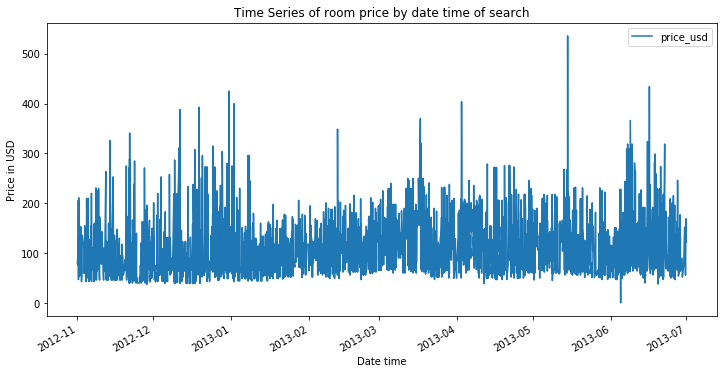

In [19]:
# plot the data
df.plot(x='date_time', y='price_usd', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Price in USD')
plt.title('Time Series of room price by date time of search');

In [20]:
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool
3945840,2012-11-01 02:48:30,84.000,19,0
63387,2012-11-01 03:06:43,78.000,16,1
3352426,2012-11-01 09:04:18,114.000,56,1
5257418,2012-11-01 09:11:03,76.000,56,1
7091061,2012-11-01 10:15:25,128.000,0,1


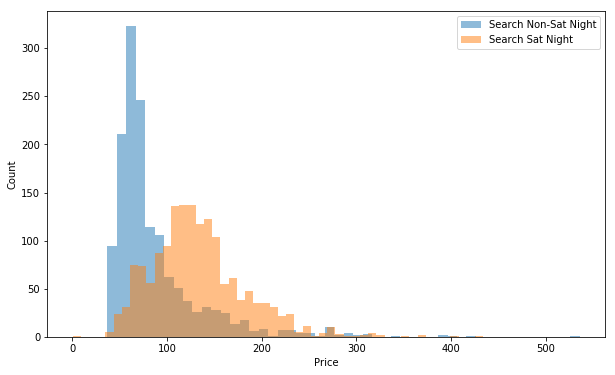

In [21]:
a = df.loc[df['srch_saturday_night_bool'] == 0, 'price_usd']
b = df.loc[df['srch_saturday_night_bool'] == 1, 'price_usd']
plt.figure(figsize=(10, 6))
plt.hist(a, bins = 50, alpha=0.5, label='Search Non-Sat Night')
plt.hist(b, bins = 50, alpha=0.5, label='Search Sat Night')
plt.legend(loc='upper right')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show();

In general, the price is more stable and lower when searching Non-Saturday night. And the price goes up when searching Saturday night. 

In [22]:
df['srch_saturday_night_bool'].value_counts()

1    1599
0    1449
Name: srch_saturday_night_bool, dtype: int64

In [23]:
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool
3945840,2012-11-01 02:48:30,84.000,19,0
63387,2012-11-01 03:06:43,78.000,16,1
3352426,2012-11-01 09:04:18,114.000,56,1
5257418,2012-11-01 09:11:03,76.000,56,1
7091061,2012-11-01 10:15:25,128.000,0,1


The useful features for our further analysis are "price_usd", "srch_booking_window" and "srch_saturday_night_bool".

## Clustering-Based Anomaly Detection

### k-means algorithm

k-means is a widely used clustering algorithm. It creates 'k' similar clusters of data points. Data instances that fall outside of these groups could potentially be marked as anomalies.

In [72]:
# Take useful feature and standardize them
# data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
# min_max_scaler = preprocessing.StandardScaler()
# np_scaled = min_max_scaler.fit_transform(data)
# data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
# pca = PCA(n_components=3)
# data = pca.fit_transform(data)
# standardize these 2 new features
# min_max_scaler = preprocessing.StandardScaler()
# np_scaled = min_max_scaler.fit_transform(data)
# data = pd.DataFrame(np_scaled)

# n_cluster = range(1, 20)
# kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
# scores = [kmeans[i].score(data) for i in range(len(kmeans))]

# fig, ax = plt.subplots(figsize=(10,6))
# ax.plot(n_cluster, scores)
# plt.xlabel('Number of Clusters')
# plt.ylabel('Score')
# plt.title('Elbow Curve')
# plt.show();

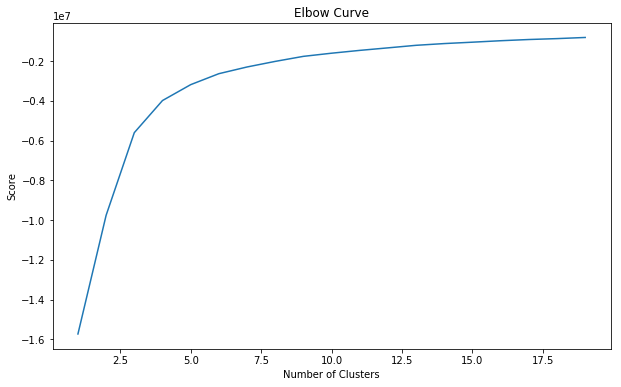

In [24]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

From the above elbow curve, we see that the graph levels off after 10 clusters, implying that addition of more clusters do not explain much more of the variance in our relevant variable; in this case price_usd.

we set n_clusters=10, and upon generating the k-means output use the data to plot the 3D clusters:

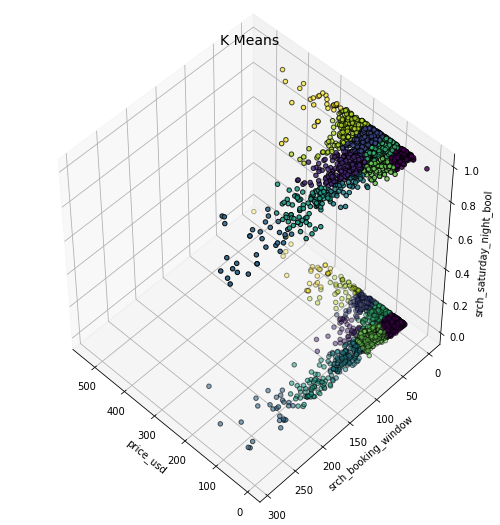

In [25]:
X = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X)
km.predict(X)
labels = km.labels_
#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("price_usd")
ax.set_ylabel("srch_booking_window")
ax.set_zlabel("srch_saturday_night_bool")
plt.title("K Means", fontsize=14);

In [74]:
# import pylab as pl

# Y = df[['price_usd']]
# X = df[['srch_booking_window']]
# Nc = range(1, 20)
# kmeans = [KMeans(n_clusters=i) for i in Nc]
# score = [kmeans[i].fit(Y).score(Y) for i in range(len(kmeans))]
# plt.figure(figsize=(10,6))
# pl.plot(Nc,score)
# pl.xlabel('Number of Clusters')
# pl.ylabel('Score')
# pl.title('Elbow Curve')
# pl.show();

In [75]:
# pca = PCA(n_components=1).fit(Y)
# pca_d = pca.transform(Y)
# pca_c = pca.transform(X)
# kmeans=KMeans(n_clusters=7)
# kmeansoutput=kmeans.fit(Y)
# pl.figure('7 Cluster K-Means')
# pl.figure(figsize=(10,6))
# pl.scatter(pca_c[:, 0], pca_d[:, 0], c=kmeansoutput.labels_)
# pl.xlabel('Search booking window')
# pl.ylabel('Price USD')
# pl.title('7 Cluster K-Means')
# pl.show();

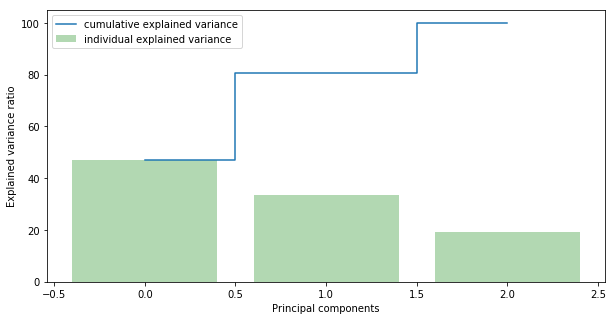

In [26]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = data.values
X_std = StandardScaler().fit_transform(X)
#Calculating Eigenvecors and eigenvalues of Covariance matrix
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

We see that the first component explains almost 50% of the variance. The second component explains over 30%. However, we've got to notice that almost none of the components are really negligible. The first 2 components contain over  80%  of the information. So, we will set n_components=2.

In [27]:
# Take useful feature and standardize them
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
# reduce to 2 important features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [90]:
# calculate with different number of centroids to see the loss plot (elbow method)
# n_cluster = range(1, 20)
# kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
# scores = [kmeans[i].score(data) for i in range(len(kmeans))]

# fig, ax = plt.subplots(figsize=(10,6))
# ax.plot(n_cluster, scores)
# plt.xlabel('Number of Clusters')
# plt.ylabel('Score')
# plt.show();

In [28]:
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
df['cluster'] = kmeans[9].predict(data)
df.index = data.index
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

9    661
8    593
7    429
2    355
0    354
3    212
6    150
4    149
5     79
1     66
Name: cluster, dtype: int64

In [29]:
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool,cluster,principal_feature1,principal_feature2
0,2012-11-01 02:48:30,84.000,19,0,9,-0.890,-0.522
1,2012-11-01 03:06:43,78.000,16,1,7,0.231,-0.272
2,2012-11-01 09:04:18,114.000,56,1,0,0.567,0.547
3,2012-11-01 09:11:03,76.000,56,1,0,0.156,0.582
4,2012-11-01 10:15:25,128.000,0,1,8,0.794,-0.659


### Clustering Approach

The underline assumption in the clustering approach is that if we cluster the data, normal data will belong to clusters while anomalies will not belong to any clusters or belong to small clusters.

In [93]:
#plot the different clusters with the 2 main features
# fig, ax = plt.subplots(figsize=(10,6))
# colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey'}
# ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
# plt.show();

In [30]:
# return Series of distance between each point and its distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[9])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


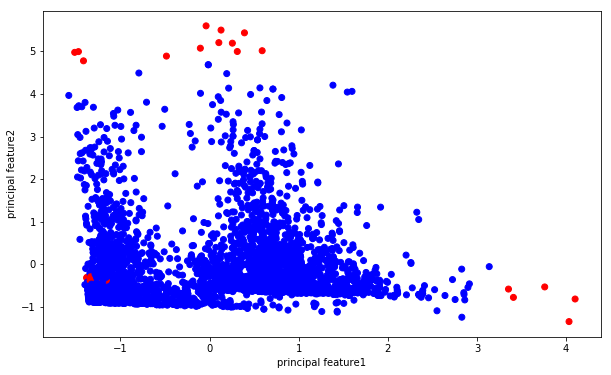

In [31]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

In [32]:
df.anomaly1.value_counts()

0    3018
1      30
Name: anomaly1, dtype: int64

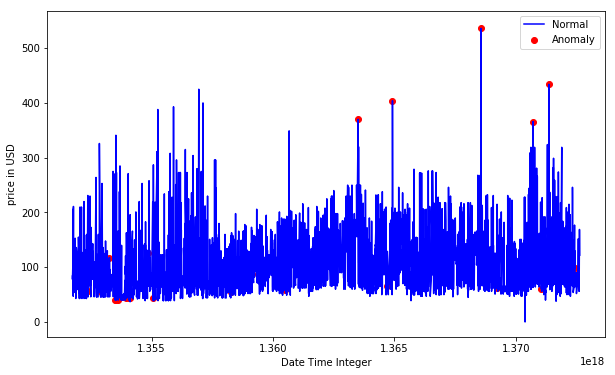

In [33]:
df = df.sort_values('date_time')
df['date_time_int'] = df.date_time.astype(np.int64)
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly1'] == 1, ['date_time_int', 'price_usd']] #anomaly

ax.plot(df['date_time_int'], df['price_usd'], color='blue', label='Normal')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label='Anomaly')
plt.xlabel('Date Time Integer')
plt.ylabel('price in USD')
plt.legend()
plt.show();

Visualization of anomaly with re-partition

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


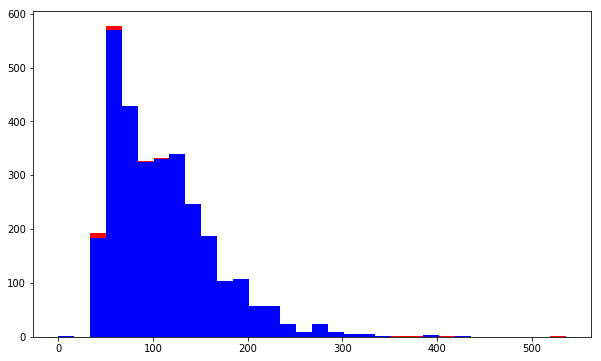

In [34]:
a = df.loc[df['anomaly1'] == 0, 'price_usd']
b = df.loc[df['anomaly1'] == 1, 'price_usd']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show();

### Isolation Forest for anomaly detection.

The IsolationForest "isolates" observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeable shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


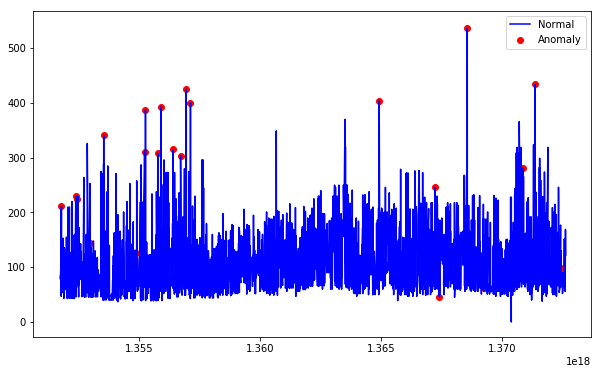

In [35]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)

df['anomaly2'] = pd.Series(model.predict(data))
# df['anomaly2'] = df['anomaly2'].map( {1: 0, -1: 1} )

fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly2'] == -1, ['date_time_int', 'price_usd']] #anomaly

ax.plot(df['date_time_int'], df['price_usd'], color='blue', label = 'Normal')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

In [36]:
df['anomaly2'].unique()

array([ 1, -1], dtype=int64)

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


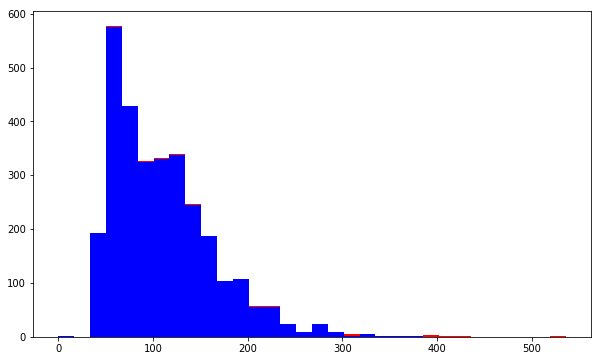

In [37]:
# visualisation of anomaly with avg price repartition
a = df.loc[df['anomaly2'] == 1, 'price_usd']
b = df.loc[df['anomaly2'] == -1, 'price_usd']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show();

## Support Vector Machine-Based Anomaly Detection

A support vector machine is another effective technique for detecting anomalies. A SVM is typically associated with supervised learning, but OneClassSVM can be used to identify anomalies as an unsupervised problems.

### One class SVM

Unsupervised Outlier Detection.

Estimate the support of a high-dimensional distribution.

The implementation is based on libsvm.

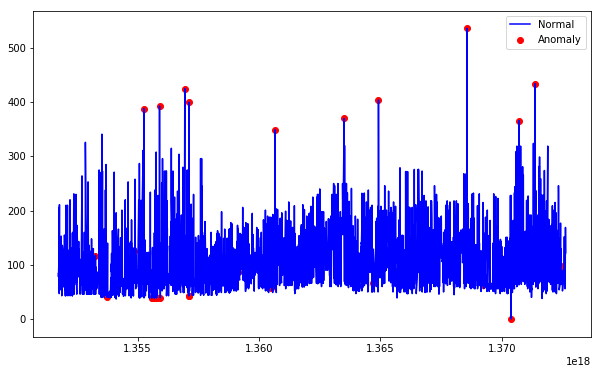

In [90]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train oneclassSVM 
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(data)
 
df['anomaly3'] = pd.Series(model.predict(data))
# df['anomaly3'] = df['anomaly3'].map( {1: 0, -1: 1} )
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly3'] == -1, ['date_time_int', 'price_usd']] #anomaly

ax.plot(df['date_time_int'], df['price_usd'], color='blue', label ='Normal')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


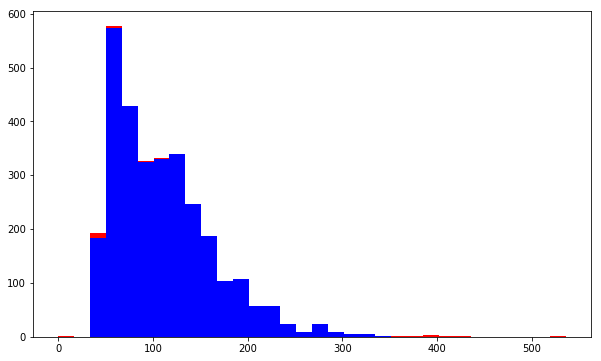

In [42]:
a = df.loc[df['anomaly3'] == 1, 'price_usd']
b = df.loc[df['anomaly3'] == -1, 'price_usd']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show();

### Anomaly Detection using Gaussian Distribution

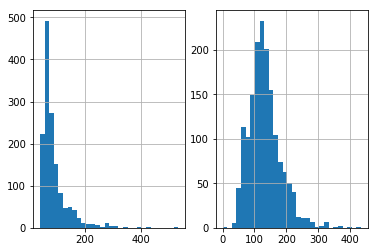

In [82]:
df_class0 = df.loc[df['srch_saturday_night_bool'] == 0, 'price_usd']
df_class1 = df.loc[df['srch_saturday_night_bool'] == 1, 'price_usd']

fig, axs = plt.subplots(1,2)
df_class0.hist(ax=axs[0], bins=30)
df_class1.hist(ax=axs[1], bins=30);

In [85]:
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


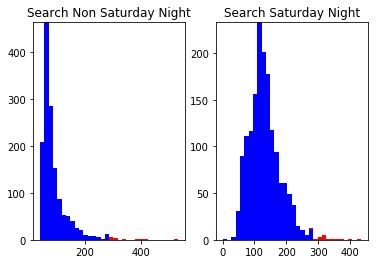

In [58]:
# plot the price repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'price_usd']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'price_usd']

a2 = df_class1.loc[df_class1['anomaly'] == 1, 'price_usd']
b2 = df_class1.loc[df_class1['anomaly'] == -1, 'price_usd']

fig, axs = plt.subplots(1,2)
axs[0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'])
axs[1].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'])
axs[0].set_title("Search Non Saturday Night")
axs[1].set_title("Search Saturday Night")
plt.show();

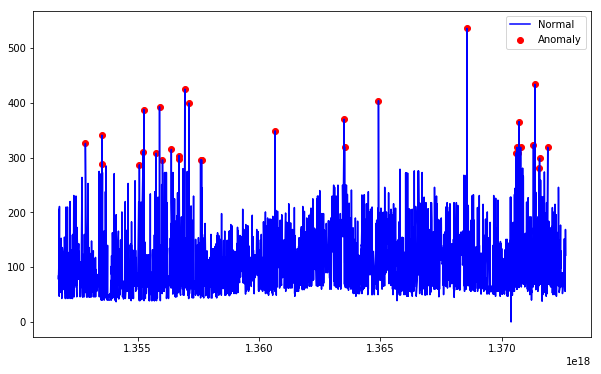

In [91]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1])
df['anomaly5'] = df_class['anomaly']
# df['anomaly5'] = np.array(df['anomaly22'] == -1).astype(int)
fig, ax = plt.subplots(figsize=(10, 6))
a = df.loc[df['anomaly5'] == -1, ('date_time_int', 'price_usd')] #anomaly
ax.plot(df['date_time_int'], df['price_usd'], color='blue', label='Normal')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label='Anomaly')
plt.legend()
plt.show();

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


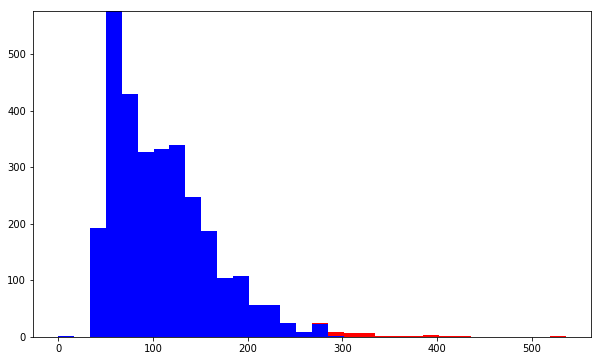

In [61]:
a = df.loc[df['anomaly5'] == 1, 'price_usd']
b = df.loc[df['anomaly5'] == -1, 'price_usd']

fig, axs = plt.subplots(figsize=(10, 6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show();

### Markov Chain

Markov chains can measure the probability of a sequence of events happening. This approach builds a Markov chain for the underline process, and when a sequence of events has happened, we can use the Markov Chain to measure the probability of that sequence occurring and use that to detect any rare sequences.

In our price anomaly detection project, we need discretize the data points in define states for markov chain. We will take 'price_usd' to define state for this example and define 5 levels of value (very low, low, average, high, very high)/(VL, L, A, H, VH). Then Markov chains would represent by states VL, L, L, A, A, H, H, VH. And each price would be a price from one state to another state. We can build the Markov chain using historical price data and use the chain to calculate sequence probabilities. Then, we can find the probability of any new sequence happening and then mark rare sequences as anomalies.

In [197]:
df['price_usd'].describe()

count   3048.000
mean     111.144
std       55.055
min        0.120
25%       67.000
50%      100.000
75%      141.000
max      536.000
Name: price_usd, dtype: float64

In [198]:
# train markov model to get transition matrix
def getTransitionMatrix (df):
    df = np.array(df)
    model = msm.estimate_markov_model(df, 1)
    return model.transition_matrix

# return the success probability of the state change 
def successProbabilityMetric(state1, state2, transition_matrix):
    proba = 0
    for k in range(0,len(transition_matrix)):
        if (k != (state2-1)):
            proba += transition_matrix[state1-1][k]
    return 1-proba

# return the success probability of the whole sequence
def sucessScore(sequence, transition_matrix):
    proba = 0 
    for i in range(1,len(sequence)):
        if(i == 1):
            proba = successProbabilityMetric(sequence[i-1], sequence[i], transition_matrix)
        else:
            proba = proba*successProbabilityMetric(sequence[i-1], sequence[i], transition_matrix)
    return proba

# return if the sequence is an anomaly considering a threshold
def anomalyElement(sequence, threshold, transition_matrix):
    if (sucessScore(sequence, transition_matrix) > threshold):
        return 0
    else:
        return 1

# return a dataframe containing anomaly result for the whole dataset 
# choosing a sliding windows size (size of sequence to evaluate) and a threshold
def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

In [201]:
# definition of the different state
x1 = (df['price_usd'] <=55).astype(int)
x2= ((df['price_usd'] > 55) & (df['price_usd']<=200)).astype(int)
x3 = ((df['price_usd'] > 200) & (df['price_usd']<=300)).astype(int)
x4 = ((df['price_usd'] > 300) & (df['price_usd']<=400)).astype(int)
x5 = (df['price_usd'] >400).astype(int)
df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5

# getting the anomaly labels for our dataset (evaluating sequence of 5 values and anomaly = less than 20% probable)
df_anomaly = markovAnomaly(df_mm, 5, 0.20)
df_anomaly = pd.Series(df_anomaly)
print(df_anomaly.value_counts())

0    2998
1      50
dtype: int64


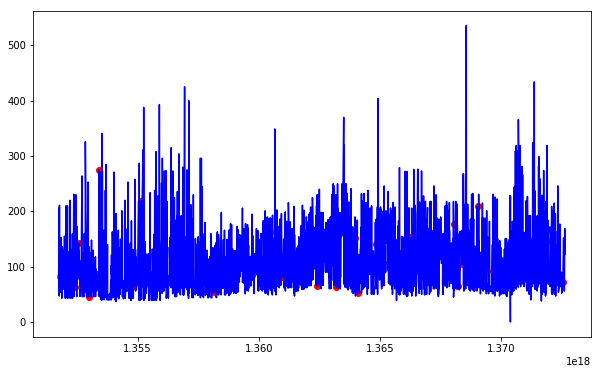

In [202]:
df['anomaly24'] = df_anomaly

fig, ax = plt.subplots(figsize=(10, 6))

a = df.loc[df['anomaly24'] == 1, ('date_time_int', 'price_usd')] #anomaly

ax.plot(df['date_time_int'], df['price_usd'], color='blue')
ax.scatter(a['date_time_int'],a['price_usd'], color='red')
plt.show();

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


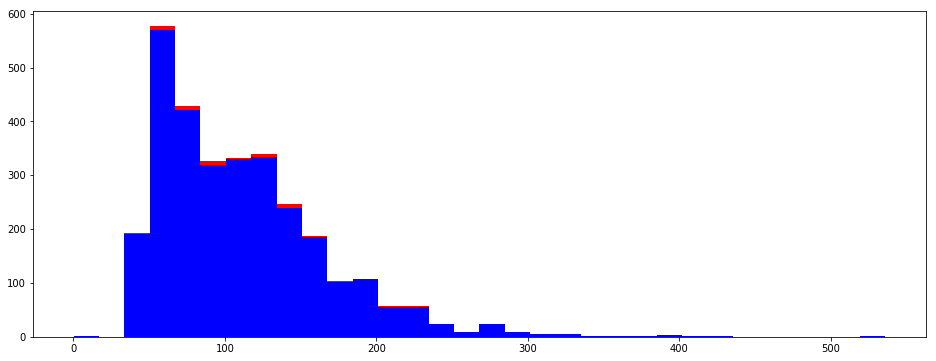

In [203]:
a = df.loc[df['anomaly24'] == 0, 'price_usd']
b = df.loc[df['anomaly24'] == 1, 'price_usd']

fig, axs = plt.subplots(figsize=(16,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show();

Because our anomaly detection is unsupervised learning.  After building the models, we have no idea how well it is doing as we have nothing to test it against. Hence, the results of those methods need to be tested in the field before placing them in the critical path.